Aim:
Finding a suitable model for classification of leukemic B-lymphoblast cells from normal B-lymphoid precursors from blood smear microscopic images. 

We have used a CNN model and some pretrained models like ResNet50, VGG16, VGG19 and InceptionV3 in this process.
After training the models for 15 epochs, the VGG19 model came up with the highest accuracy among all of them with about ~78% accuracy and VGG16 was the second highest with a little less accuracy than the former with about ~77%.

The reason behind VGG models getting so much higher accuracy in comparison to others is its architecture, the main key points of this architecture are as follows: 

*    Use of very small convolutional filters, e.g. 3×3 and 1×1 with a stride of one.
*    Use of max pooling with a size of 2×2 and a stride of the same dimensions.
*    The importance of stacking convolutional layers together before using a pooling layer to define a block.
*    Dramatic repetition of the convolutional-pooling block pattern.
*    Development of very deep (16 and 19 layer) models.




In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
# Any results you write to the current directory are saved as output.

['blood-cancer-training-dataset', 'blood-cancer-test-dataset']


In [58]:
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, DepthwiseConv2D
from keras import backend as K
import itertools
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [59]:
os.listdir("../input")

['blood-cancer-training-dataset', 'blood-cancer-test-dataset']

In [60]:
# This cell can be used to access and use the TEST dataset available

# data = pd.read_csv("../input/blood-cancer-test-dataset/c-nmc_test_prelim_phase_data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data_labels.csv")
# print(data.head())

# baseadd = "../input/blood-cancer-test-dataset/c-nmc_test_prelim_phase_data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data"
# image_path_dict = {os.path.basename(x): x for x in glob(os.path.join(baseadd, "*.bmp"))}
# data["path"] = (data["new_names"]).map(image_path_dict.get)
# data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((224, 224))))
# data["image"].shape
# print(data.head())

# data["Patient_ID"][0].split('_')
# subject_id_dict = {data["Patient_ID"][x]: data["Patient_ID"][x].split("_")[1] for x in range(len(data["Patient_ID"]))}
# image_id_dict = {data["Patient_ID"][x]: data["Patient_ID"][x].split("_")[2] for x in range(len(data["Patient_ID"]))}
# cell_id_dict = {data["Patient_ID"][x]: data["Patient_ID"][x].split("_")[3] for x in range(len(data["Patient_ID"]))}

# data["subject_id"] = data["Patient_ID"].map(subject_id_dict.get)
# data["image_id"] = data["Patient_ID"].map(image_id_dict.get)
# data["cell_no"] = data["Patient_ID"].map(cell_id_dict.get)
# # data["cell_state"] = data["Patient_ID"].map(cell_type_id_dict.get)
# subject_filter_dict = {data["subject_id"][x]: data["subject_id"][x][1:] if "H" in data["subject_id"][x] 
#                        else data["subject_id"][x] for x in range(len(data["Patient_ID"]))}
# data["subject_id"] = data["subject_id"].map(subject_filter_dict.get)
# print(data.sample(5))

# plt.imshow(data["image"][0])
# plt.axis("off")

# data["labels"].value_counts().plot(kind = "bar")
# print(data["labels"].value_counts())

# plt.scatter(data['subject_id'], data['cell_no'])
# plt.title("Subject Id distribution")

# data['subject_id'].value_counts().plot(kind = 'bar')
# plt.title("Subject Id dis")

## Preprocessing the data

In [61]:
baseadd_tr = "../input/blood-cancer-training-dataset/c-nmc_training_data(1)/C-NMC_training_data"
image_path_dict_tr = {os.path.basename(x).split(".")[0]: x for x in glob(os.path.join(baseadd_tr, "*", "*", "*.bmp"))}

In [62]:
data_tr = pd.DataFrame()
password = [os.path.basename(x).split(".")[0] for x in glob(os.path.join(baseadd_tr, "*", "*", "*.bmp"))]
data_tr["Patient_ID"] = password
data_tr.head()

,Patient_ID
0,UID_H14_26_1_hem
1,UID_H10_63_1_hem
2,UID_H14_30_6_hem
3,UID_H10_190_3_hem
4,UID_H14_19_15_hem


In [63]:
data_tr["path"] = data_tr["Patient_ID"].map(image_path_dict_tr.get)
data_tr['image'] = data_tr['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 100))))
data_tr.head()

,Patient_ID,path,image
0,UID_H14_26_1_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,UID_H10_63_1_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,UID_H14_30_6_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,UID_H10_190_3_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,UID_H14_19_15_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [64]:
data_tr["image"].shape

(10661,)

In [65]:
data_tr["Patient_ID"][0].split('_')
subject_id_dict_tr = {data_tr["Patient_ID"][x]: data_tr["Patient_ID"][x].split("_")[1] for x in range(len(data_tr["Patient_ID"]))}
image_id_dict_tr = {data_tr["Patient_ID"][x]: data_tr["Patient_ID"][x].split("_")[2] for x in range(len(data_tr["Patient_ID"]))}
cell_id_dict_tr = {data_tr["Patient_ID"][x]: data_tr["Patient_ID"][x].split("_")[3] for x in range(len(data_tr["Patient_ID"]))}
data_tr["subject_id"] = data_tr["Patient_ID"].map(subject_id_dict_tr.get)
data_tr["image_id"] = data_tr["Patient_ID"].map(image_id_dict_tr.get)
data_tr["cell_no"] = data_tr["Patient_ID"].map(cell_id_dict_tr.get)
# data["cell_state"] = data["Patient_ID"].map(cell_type_id_dict.get)
subject_filter_dict_tr = {data_tr["subject_id"][x]: data_tr["subject_id"][x][1:] if "H" in data_tr["subject_id"][x] 
                       else data_tr["subject_id"][x] for x in range(len(data_tr["Patient_ID"]))}
data_tr["subject_id"] = data_tr["subject_id"].map(subject_filter_dict_tr.get)
data_tr.sample(5)

,Patient_ID,path,image,subject_id,image_id,cell_no
8279,UID_52_18_4_all,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",52,18,4
4280,UID_H23_5_5_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",23,5,5
2285,UID_34_6_4_all,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",34,6,4
4172,UID_H2_29_2_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2,29,2
3603,UID_H40_24_5_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",40,24,5


In [66]:
# 0 means normal cell, while 1 means a cancer diagnosed cell
label_dict = {password[x] : password[x].split("_")[-1] for x in range(len(password))}
data_tr["labels"] = data_tr["Patient_ID"].map(label_dict.get)
data_tr["labels"] = data_tr["labels"].apply(lambda x: 1 if x == 'all' else 0)
data_tr.sample(5)

,Patient_ID,path,image,subject_id,image_id,cell_no,labels
4860,UID_68_29_12_all,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",68,29,12,1
8424,UID_52_37_7_all,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",52,37,7,1
963,UID_H14_34_2_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",14,34,2,0
2691,UID_51_8_2_all,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",51,8,2,1
3624,UID_H9_30_1_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",9,30,1,0


In [67]:
# Deleting dicts and list whose work is done in order to free our memory.
del image_path_dict_tr
del password
del subject_id_dict_tr
del image_id_dict_tr
del cell_id_dict_tr
del subject_filter_dict_tr
del baseadd_tr
del label_dict

(-0.5, 99.5, 99.5, -0.5)

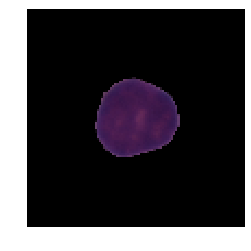

In [68]:
plt.imshow(data_tr["image"][4])
plt.axis("off")

1    7272
0    3389
Name: labels, dtype: int64

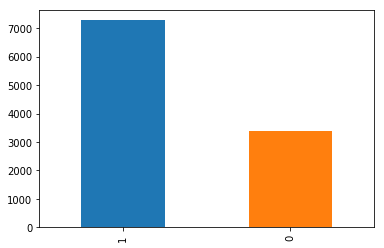

In [69]:
data_tr["labels"].value_counts().plot(kind = "bar")
data_tr["labels"].value_counts()

<Figure size 4320x4320 with 0 Axes>

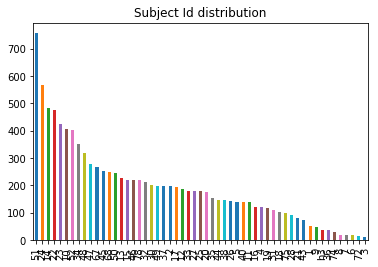

<Figure size 4320x4320 with 0 Axes>

In [70]:
data_tr['subject_id'].value_counts().plot(kind = 'bar')
plt.title("Subject Id distribution")
plt.figure(figsize = (60, 60))

In [71]:
X = data_tr.drop(["labels"], axis = 1)
y = data_tr["labels"]

%age of label value 0 in training dataset 0.3191838649155722
%age of label value 0 in test dataset 0.3127051101734646


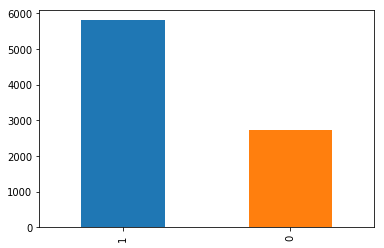

In [72]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

y_train.value_counts().plot(kind = "bar")
y_test.value_counts().plot(kind = "bar")

print("%age of label value 0 in training dataset", 
      y_train.value_counts()[0]/(y_train.value_counts()[0]+y_train.value_counts()[1]))
print("%age of label value 0 in test dataset", 
      y_test.value_counts()[0]/(y_test.value_counts()[0]+y_test.value_counts()[1]))
del X, y

In [73]:
# Normalization
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_test_mean = np.mean(x_test)

x_train_std = np.std(x_train)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

y_dopetest = y_test
# Label Encoding
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

# Reshape images in 3 dimensions
x_train = x_train.reshape(x_train.shape[0], *(100, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 100, 3))
x_train.shape

(8528, 100, 100, 3)

## Defining models to train on our dataset

In [18]:
input_shape = (100, 100, 3)
num_classes = 2
# Set learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, 
                                           factor = 0.5, min_lr = 0.00001)

# Data Augmentation
datagen = ImageDataGenerator(featurewise_center = False, samplewise_center = True,
                            featurewise_std_normalization = False, samplewise_std_normalization = False, 
                            zca_whitening = False, rotation_range = 0, zoom_range = 0.3, 
                            width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = False, 
                            vertical_flip = False, rescale = 1./255)
datagen.fit(x_train)
# print(datagen.mean, datagen.std)
# datagen.standardize(x_test)
print(x_test.shape)
for i in range(len(x_test)):
    # this is what you are looking for
    x_test[i] = datagen.standardize(x_test[i])
print(x_test.shape)

# Define the optimizer
# optimizer = Adam(lr = .001, beta_1 = .9, beta_2 = .999, epsilon = None, decay = .0, amsgrad = False)
# Fit the model
# 
# epochs = 20
# batch_size = 80

(2133, 100, 100, 3)
(2133, 100, 100, 3)


Defining and fitting Capsule network

In [19]:

from __future__ import print_function
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
# from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator


# the squashing function.
# we use 0.5 instead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like time distributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'keras':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)


batch_size = 128
num_classes = 2
epochs = 20
# # (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# # x_train = x_train.astype('float32')
# # x_test = x_test.astype('float32')
# # x_train /= 255
# # x_test /= 255
# # y_train = utils.to_categorical(y_train, num_classes)
# # y_test = utils.to_categorical(y_test, num_classes)

# A common Conv2D model
input_image = Input(shape=(None, None, 3))
x = Conv2D(64, (3, 3), activation='relu')(input_image)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x = Reshape((-1, 128))(x)
capsule = Capsule(2, 16, 3, True)(x)
capsule = Dense(1, activation = 'sigmoid')(capsule)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model_caps = Model(inputs=input_image, outputs=output)

# we use a margin loss
model_caps.compile(loss=margin_loss, optimizer= optimizers.Adam(lr = 0.001), metrics=['mae', 'acc'])
model_caps.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

if not data_augmentation:
    print('Not using data augmentation.')
    model_caps.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        steps_per_epoch = x_train.shape[0] // batch_size)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen1 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(
        datagen1.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        steps_per_epoch = x_train.shape[0] // batch_size,
        workers=4)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, None, None, 64)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 128)   147584    
_________________________________________________________________
average_pooling2d_2 (Average (None, None, None, 128)   0         
__________

### Fitting our pretrained models

Densenet

In [ ]:
# from keras.applications.densenet import DenseNet121
# model_densenet = Sequential()
# model_densenet.add(DenseNet121(include_top=False, pooling= 'max', weights='imagenet'))
# model_densenet.add(Dense(num_classes, activation = "sigmoid"))

# model_densenet.trainable = False

# model_densenet.compile(optimizer = "Adamax", loss = "categorical_crossentropy", 
#                        metrics = ['mae', 'accuracy'])

# print("*"*40 + "Densenet model" + "*"*40)
# history = model_densenet.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                            verbose = 1,
#                            epochs = epochs,
#                            steps_per_epoch= x_train.shape[0] // batch_size, 
#                             callbacks = [learning_rate_reduction],
#                            validation_data = (x_test, y_test))

In [20]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.applications import ResNet50, VGG16, VGG19, InceptionV3
# Using pretrained models for VGG16, VGG19, resnet, InceptionV3
# If you are using Kaggle kernel, do switch ON the Internet from Settings.

# from keras.applications.nasnet import NASNetMobile
# model_nasnet = Sequential()
# model_nasnet.add(NASNetMobile(input_shape=None, include_top=False, 
#                              weights='imagenet', input_tensor=None, pooling='max', classes=1000))
# model_nasnet.add(Dense(num_classes, activation = "softmax"))

# from keras.applications.mobilenet_v2 import MobileNetV2
# model_mobile = Sequential()
# model_mobile.add(MobileNetV2(input_shape=None, alpha=1.0, 
#                         include_top=False, weights='imagenet', input_tensor=None, pooling='max'))
# model_mobile.add(Dense(num_classes, activation = "softmax"))

# model_resnet = Sequential()
# model_resnet.add(ResNet50(include_top=False, pooling='max', weights= "imagenet"))
# model_resnet.add(Dense(num_classes, activation='softmax'))

# model_vgg16 = Sequential()
# model_vgg16.add(VGG16(include_top= False, pooling = "max", weights = "imagenet"))
# model_vgg16.add(Dense(num_classes, activation = "softmax"))

model_vgg19 = Sequential()
model_vgg19.add(VGG19(include_top= False, pooling = "max", weights = "imagenet"))
model_vgg19.add(Dense(num_classes, activation = "softmax"))

# model_inception = Sequential()
# model_inception.add(InceptionV3(include_top= False, pooling = "max", weights = "imagenet"))
# model_inception.add(Dense(num_classes, activation = "softmax"))

# Say not to train first layer (ResNet) model. It is already trained
# model_nasnet.layers[0].trainable = False
# model_mobile.layers[0].trainable = False
# model_resnet.layers[0].trainable = False
# model_vgg16.layers[0].trainable = False
model_vgg19.layers[0].trainable = False
# model_inception.layers[0].trainable = False

80142336/80134624 [==============================] - 1s 0us/step


In [23]:
# Compile the pretrained models
# model_nasnet.compile(optimizer= "Adamax", loss='categorical_crossentropy', metrics=['accuracy'])

# model_mobile.compile(optimizer= "Adamax", loss='categorical_crossentropy', metrics=['accuracy'])

# model_resnet.compile(optimizer= "Adamax", loss='categorical_crossentropy', metrics=['accuracy'])

# model_vgg16.compile(optimizer = "Adamax", loss = "categorical_crossentropy", metrics = ['accuracy'])

model_vgg19.compile(optimizer = "Adamax", loss = "categorical_crossentropy", metrics = ['mae', 'accuracy'])

# model_inception.compile(optimizer = 'Adamax', loss = "categorical_crossentropy", metrics = ['accuracy'])

datagen = ImageDataGenerator(featurewise_center = False, samplewise_center = True,
                            featurewise_std_normalization = False, samplewise_std_normalization = True, 
                            zca_whitening = False, rotation_range = 0, zoom_range = 0.3, 
                            width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = False, 
                            vertical_flip = False, rescale = 1./255)
datagen.fit(x_train)
# print(datagen.mean, datagen.std)
# datagen.standardize(x_test)
print(x_test.shape)
for i in range(len(x_test)):
    # this is what you are looking for
    x_test[i] = datagen.standardize(x_test[i])
print(x_test.shape)

(2133, 100, 100, 3)
(2133, 100, 100, 3)


In [24]:
import random
random.seed(1234)
# reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,
#                               patience=3, min_lr=0.001)
# Fit the model
# print("*"*40 + "Nasnet model" + "*"*40)
# history = model_nasnet.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                            verbose = 0,
#                            epochs = epochs,
#                            steps_per_epoch=x_train.shape[0] // batch_size,
#                                      callbacks = [learning_rate_reduction],
#                            validation_data = (x_test, y_test))

# print("*"*40 + "Mobile model" + "*"*40)
# history = model_mobile.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                            verbose = 0,
#                            epochs = epochs,
#                            steps_per_epoch=x_train.shape[0] // batch_size,
#                                      callbacks = [learning_rate_reduction],
#                            validation_data = (x_test, y_test))

# print("*"*40 + "ResNet50 model" + "*"*40)
# history = model_resnet.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                            verbose = 1,
#                            epochs = epochs,
#                            steps_per_epoch=x_train.shape[0] // batch_size,
#                                      callbacks = [learning_rate_reduction],
#                            validation_data = (x_test, y_test))
# print("*"*40 + "VGG16 model" + "*"*40)
# history = model_vgg16.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                            verbose = 1,
#                            epochs = epochs,
#                            steps_per_epoch=x_train.shape[0] // batch_size, 
#                             callbacks = [learning_rate_reduction], 
#                             validation_data = (x_test, y_test))
batch_size = 128
num_classes = 2
epochs = 20
print("*"*40 + "VGG19 model" + "*"*40)
history = model_vgg19.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           verbose = 1,
                           epochs = epochs,
                           steps_per_epoch= x_train.shape[0] // batch_size, 
                            callbacks = [learning_rate_reduction],
                           validation_data = (x_test, y_test))

# print("*"*40 + "inception model" + "*"*40)
# history = model_inception.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                            verbose = 1,
#                            epochs = epochs,
#                            steps_per_epoch=x_train.shape[0] // batch_size,
#                             callbacks = [learning_rate_reduction], 
#                            validation_data = (x_test, y_test))

****************************************VGG19 model****************************************
Epoch 1/20
66/66 [==============================] - 20s 307ms/step - loss: 0.5766 - mean_absolute_error: 0.3956 - acc: 0.7173 - val_loss: 0.5003 - val_mean_absolute_error: 0.3471 - val_acc: 0.7750
Epoch 2/20
66/66 [==============================] - 19s 286ms/step - loss: 0.5341 - mean_absolute_error: 0.3612 - acc: 0.7468 - val_loss: 0.4802 - val_mean_absolute_error: 0.3364 - val_acc: 0.7947
Epoch 3/20
66/66 [==============================] - 19s 286ms/step - loss: 0.5238 - mean_absolute_error: 0.3522 - acc: 0.7527 - val_loss: 0.4764 - val_mean_absolute_error: 0.3158 - val_acc: 0.7843
Epoch 4/20
66/66 [==============================] - 19s 286ms/step - loss: 0.5130 - mean_absolute_error: 0.3421 - acc: 0.7605 - val_loss: 0.4734 - val_mean_absolute_error: 0.3087 - val_acc: 0.7843
Epoch 5/20
66/66 [==============================] - 19s 289ms/step - loss: 0.5149 - mean_absolute_error: 0.3413 - acc: 0

In [25]:
from os import makedirs
makedirs('models')
# fit and save models
filename = 'models/model_caps.h5'
model_caps.save(filename)
print('>Saved %s' % filename)
# filename = 'models/model_densenet.h5'
# model_densenet.save(filename)
# print('>Saved %s' % filename)
filename = 'models/model_VGG19.h5'
model_vgg19.save(filename)
print('>Saved %s' % filename)

>Saved models/model_caps.h5
>Saved models/model_VGG19.h5


In [29]:
model_caps.evaluate(x_test, y_test, verbose = 0)

[0.22947375287039426, 0.38177686662837146, 0.6872948900221437]

In [32]:
model_vgg19.evaluate(x_test, y_test, verbose = 0)

[0.4703933731720473, 0.2983389174329022, 0.787623066243799]

In [36]:
# from keras.models import load_model
members = []
# filename = 'models/model_caps.h5'
# model = load_model(filename)
members.append(model_caps)
# filename = 'models/model_VGG19.h5'
# model = load_model(filename)
members.append(model_vgg19)
# del model
members

In [53]:
for model in members:
    acc = model.evaluate(x_test, y_test, verbose=0)[-1]
    print('Model Accuracy: %.3f' % acc)
model_vgg19.predict(x_test, verbose=0).shape

Model Accuracy: 0.687
Model Accuracy: 0.788


(2133, 2)

In [76]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = np.dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = LogisticRegression()
    model.fit(stackedX, inputy)
    return model

# fit stacked model using the ensemble
model = fit_stacked_model(members, x_test, y_dopetest)

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

# evaluate model on test set
yhat = stacked_prediction(members, model, x_test)
acc = accuracy_score(y_dopetest, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Stacked Test Accuracy: 0.799


In [ ]:
# from keras.applications.resnet import ResNet152
# model_dop = ResNet152(include_top=False, weights='imagenet', pooling="max")
# model_dop.add(Dense(num_classes, activation = "softmax"))
# model_dop.layers[0].trainable = False
# model_dop.compile(optimizer= "Adamax", loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
# print("*"*40 + "ResNeXt101 model" + "*"*40)
# history = model_dop.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                            verbose = 1,
#                            epochs = epochs,
#                            steps_per_epoch=x_train.shape[0] // batch_size,
#                                      callbacks = [learning_rate_reduction],
#                            validation_data = (x_test, y_test))

| Model/Architecture | Type | Optimizer | Accuracy(in %) |
| --- | --- | --- | --- |
| CNN | Raw | Adam | ~65 ||
| ResNet50 | Pre-Trained | sgd | ~64 |
| VGG16 | Pre-Trained | sgd | ~77 |
| VGG19 | Pre-Trained | sgd | ~79 |
| Inception | Pre-Trained | sgd | ~64 |
| VGG16 | Pre-Trained | Adam | ~81 |
| VGG19 | Pre-Trained | Adam | ~83 |
| VGG16 | Pre-Trained | Adamax | ~79 |
| VGG19 | Pre-Trained | Adamax | ~78 |
| VGG16 | Pre-Trained | Nadam | ~80 |
| VGG19 | Pre-Trained | Nadam | ~79 |